# **Urbanization and Vegetation Change Analysis (2013-2023) using Google Earth Engine**

1. Install & Import Libraries

In [1]:
!pip install geemap --quiet

import ee
import geemap
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Authenticate and intialize Earth Engine
ee.Authenticate()
ee.Initialize(project='gee-lahore-lulc')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


2. Define study area and time

In [43]:
city_name = "Lahore, Pakistan"

# Manually define Lahore coordinates
coords = [74.3587, 31.5204]

# Create ROI geometry
roi = ee.Geometry.Point(coords).buffer(10000)

# Create and display map
Map = geemap.Map(center=coords[::-1], zoom=9)
Map.add_basemap('SATELLITE')

print(f"Region of Interest: {city_name}")
print("Coordinates:", coords)

# Define analysis periods
periods = {
    "2013": ("2013-01-01", "2013-12-31"),
    "2018": ("2018-01-01", "2018-12-31"),
    "2023": ("2023-01-01", "2023-12-31")
}

Map


Region of Interest: Lahore, Pakistan
Coordinates: [74.3587, 31.5204]


Map(center=[31.5204, 74.3587], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

3. Fetch and Preprocess Landsat Imagery

In [44]:
def get_landsat_image(start, end, region):
    """Fetches median Landsat 8/9 image, masks clouds, and scales reflectance."""
    landsat8 = (
        ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        .filterDate(start, end)
        .filterBounds(region)
        .map(lambda img: img.updateMask(img.select('QA_PIXEL').bitwiseAnd(1 << 3).eq(0)))
        .map(lambda img: img.select(['SR_B.']).divide(10000))
    )

    landsat9 = (
        ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
        .filterDate(start, end)
        .filterBounds(region)
        .map(lambda img: img.updateMask(img.select('QA_PIXEL').bitwiseAnd(1 << 3).eq(0)))
        .map(lambda img: img.select(['SR_B.']).divide(10000))
    )

    merged = landsat8.merge(landsat9)
    return merged.median().clip(region)


images = {}
for year, (start, end) in periods.items():
    images[year] = get_landsat_image(start, end, roi)
    print(f"Landsat image for {year} loaded")


Landsat image for 2013 loaded
Landsat image for 2018 loaded
Landsat image for 2023 loaded


4. Compute NDVI and NDBI Indices

In [45]:
def calc_ndvi(image):
  """ Normalized Difference Vegetation Index """
  return image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

def calc_ndbi(image):
  """ Normalized Difference Built-up Index """
  return image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')

ndvi_images, ndbi_images = {}, {}
for year, image in images.items():
  ndvi_images[year] = calc_ndvi(image)
  ndbi_images[year] = calc_ndbi(image)

print ("NDVI and NDBI images computed")

NDVI and NDBI images computed


5. Compute Change Maps and Summary Stats

In [46]:
ndvi_change = ndvi_images["2023"].subtract(ndvi_images["2013"]).rename("NDVI Change")
ndbi_change = ndbi_images["2023"].subtract(ndbi_images["2013"]).rename("NDBI Change")

ndvi_params = {'min':0, 'max':1, 'palette':['red', 'yellow', 'green']}
ndbi_params = {'min':-0.5, 'max':0.5, 'palette':['blue', 'white', 'brown']}
change_params={'min':-0.5, 'max':0.5, 'palette':['red','white','green']}

def get_stats(image, region):
  stats=image.reduceRegion(
    reducer=ee.Reducer.mean().combine(ee.Reducer.median(),sharedInputs=True).combine(ee.Reducer.stdDev(), sharedInputs=True),
    geometry=region,
    scale=30,
    bestEffort=True
  ).getInfo()
  return stats


summary = []
for year in periods.keys():
  ndvi_stats = get_stats(ndvi_images[year], roi)
  ndbi_stats = get_stats(ndbi_images[year], roi)
  summary.append({
      "Year": year,
      "NDVI_Mean": ndvi_stats.get('NDVI_mean'),
      "NDVI_StdDev": ndvi_stats.get('NDVI_stdDev'),
      "NDBI_Mean": ndbi_stats.get('NDBI_mean'),
      "NDBI_StdDev": ndbi_stats.get('NDBI_stdDev')
  })

df_stats = pd.DataFrame(summary)
print("Statistical Summary:")
display(df_stats)

Statistical Summary:


,Year,NDVI_Mean,NDVI_StdDev,NDBI_Mean,NDBI_StdDev
0,2013,0.121360,0.056910,-0.010703,0.033970
1,2018,0.098993,0.056875,-0.007908,0.034427
2,2023,0.120461,0.065197,-0.020166,0.040753


6. Visualize NDVI and NDBI Trends

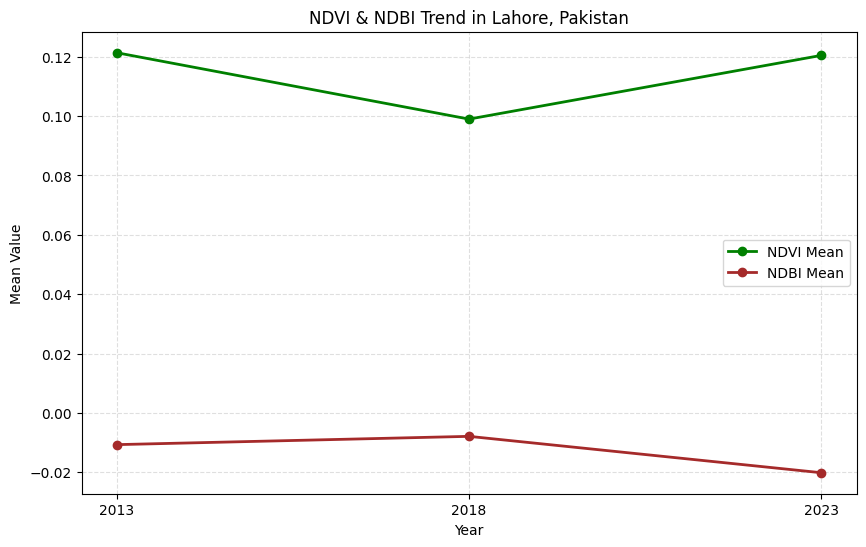

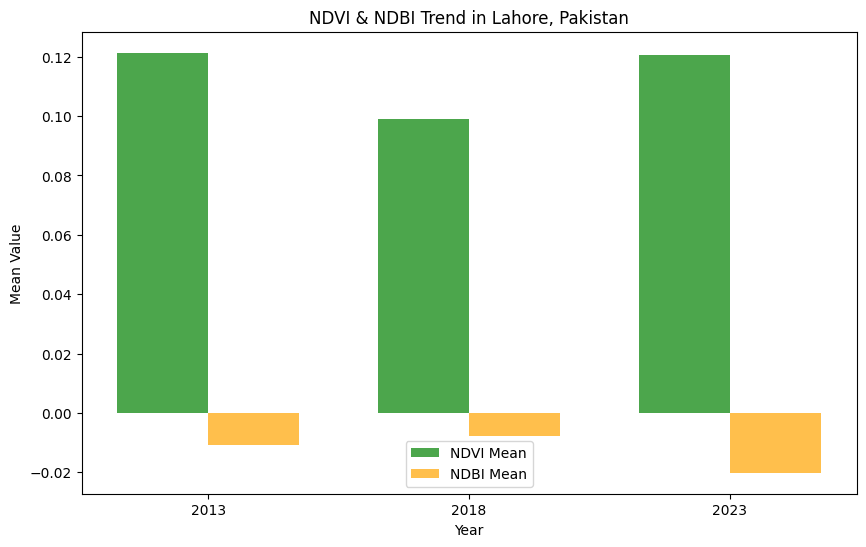

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(df_stats['Year'], df_stats['NDVI_Mean'], marker='o', linewidth=2, color='green', label='NDVI Mean')
plt.plot(df_stats['Year'], df_stats['NDBI_Mean'], marker='o', linewidth=2, color='brown', label='NDBI Mean')

plt.title(f"NDVI & NDBI Trend in {city_name}")
plt.xlabel("Year")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(alpha=0.4, linestyle='--')
plt.show()

x = np.arange(len(df_stats['Year']))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, df_stats['NDVI_Mean'], width, label='NDVI Mean', color='green', alpha=0.7)
plt.bar(x + width/2, df_stats['NDBI_Mean'], width, label='NDBI Mean', color='orange', alpha=0.7)

plt.title(f"NDVI & NDBI Trend in {city_name}")
plt.xlabel("Year")
plt.ylabel("Mean Value")
plt.legend()
plt.xticks(x, df_stats['Year'])
plt.show()

7. Interactive GEE Layers

In [49]:
Map.addLayer(ndvi_images["2013"], ndvi_params, "NDVI 2013")
Map.addLayer(ndvi_images["2023"], ndvi_params, "NDVI 2023")
Map.addLayer(ndvi_change, change_params, "NDVI Change (2023 - 2013)")

Map.addLayer(ndbi_images["2013"], ndbi_params, "NDBI 2013")
Map.addLayer(ndbi_images["2023"], ndbi_params, "NDBI 2023")
Map.addLayer(ndbi_change, change_params, "NDBI Change (2023 - 2013)")

Map.add_legend(title="NDVI Scale", legend_dict={"Low(0)": (255, 0, 0), "Medium(0.5)": (255, 255, 0), "High(1)": (0, 128, 0)})
Map.add_legend(title="NDBI Scale", legend_dict={"Low(-0.5)": (0, 0, 255), "Medium(0)": (255, 255, 255), "High(0.5)": (165, 42, 42)})
Map.add_legend(title="Change Map", legend_dict={"Decrease": (255, 0, 0), "Stable": (255, 255, 255), "Increase": (0, 128, 0)})

Map

Map(bottom=107346.0, center=[31.30864014143843, 74.09591674804689], controls=(WidgetControl(options=['position…